# Semantic Chunking

We will create a rolling window of sentence embedding and calculate the similary betweent the consequnce windows. Once the similarity is low, we will break the chunks as it means the semantic topic of the windows had changed.

In [1]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2", split="train")
dataset

/Users/guy/projects/advanced-rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 2673/2673 [00:00<00:00, 6281.54 examples/s]


Dataset({
    features: ['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'content', 'references'],
    num_rows: 2673
})

In [2]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [3]:
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger

logger.setLevel("WARNING")  # reduce logs from splitter

splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=100,
    max_split_tokens=500,
    window_size=2,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

Matplotlib is building the font cache; this may take a moment.


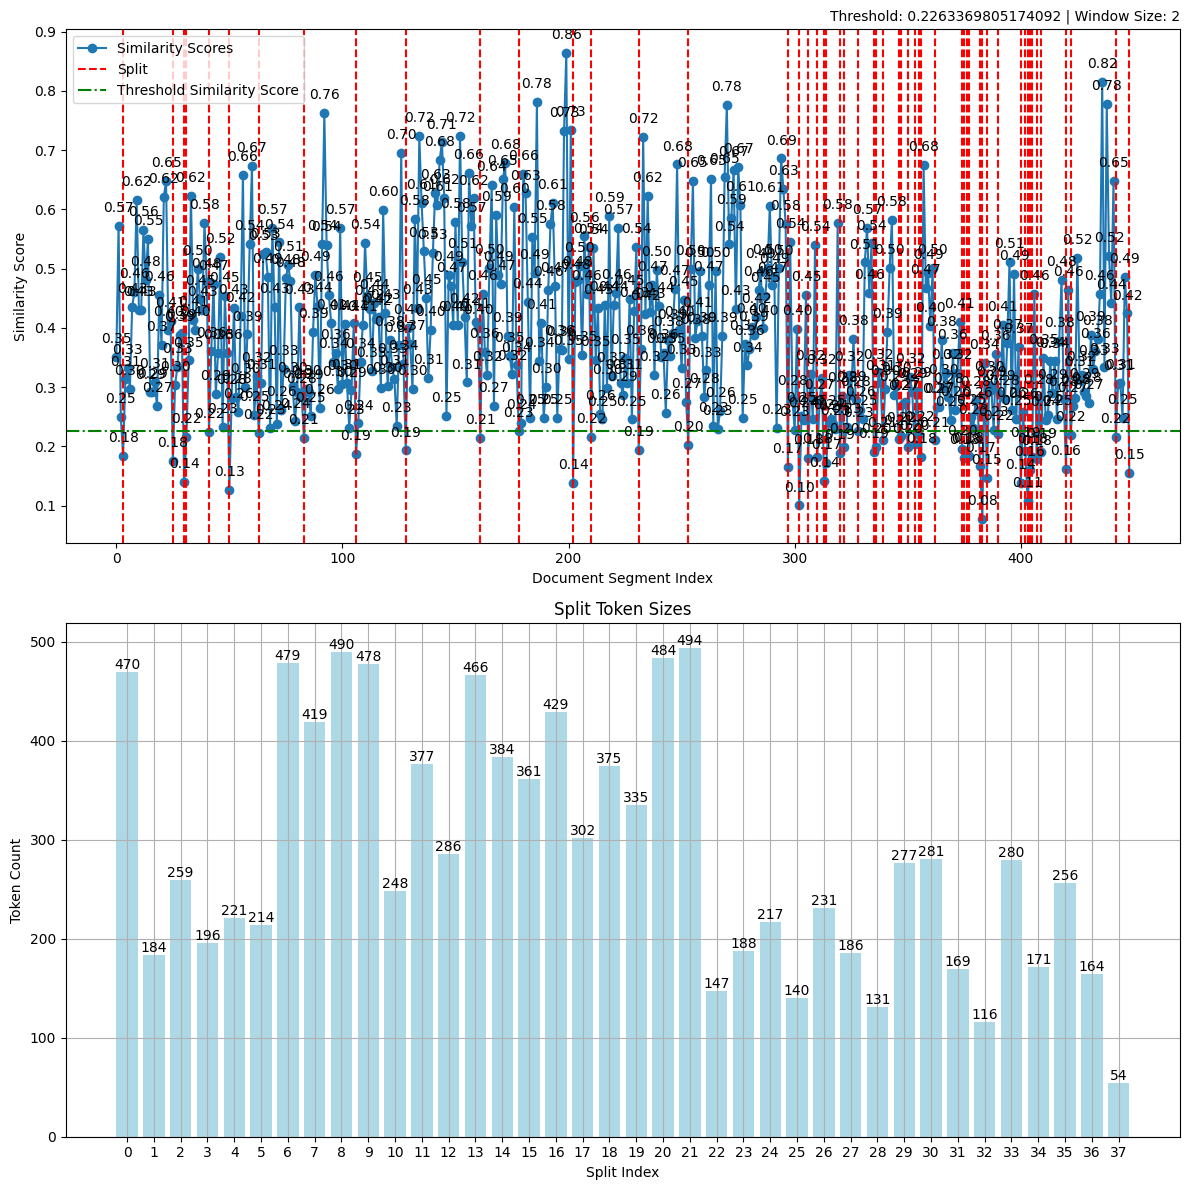

Splitting Statistics:
  - Total Documents: 450
  - Total Splits: 38
  - Splits by Threshold: 27
  - Splits by Max Chunk Size: 10
  - Last Split: 1
  - Minimum Token Size of Split: 54
  - Maximum Token Size of Split: 494
  - Similarity Split Ratio: 0.71


In [5]:
splits = splitter([dataset["content"][0]])


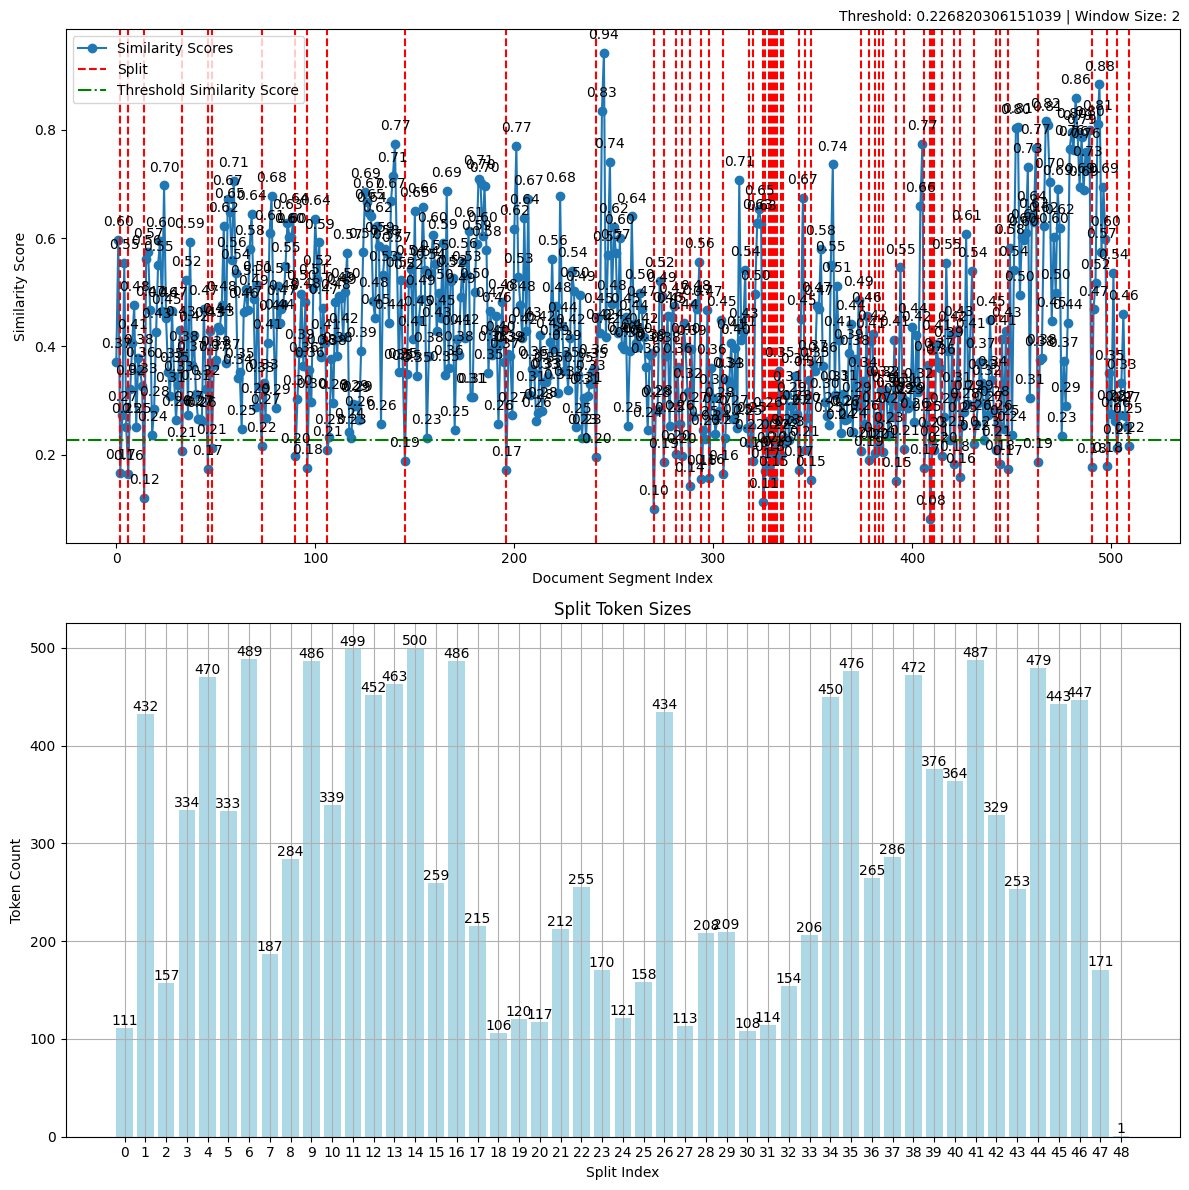

Splitting Statistics:
  - Total Documents: 511
  - Total Splits: 49
  - Splits by Threshold: 29
  - Splits by Max Chunk Size: 19
  - Last Split: 1
  - Minimum Token Size of Split: 1
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.59


In [6]:
splits = splitter([dataset["content"][1]])

In [7]:
splitter.print(splits[:3])

Split 1, tokens 111, triggered by: 0.16
3 2 0 2 c e D 8 2 ] G L . s c [ 1 v 8 3 2 7 1 . 2 1 3 2 : v i X r a # Fast Inference of Mixture-of-Experts Language Models with Offloading Artyom Eliseev Moscow Institute of Physics and Technology Yandex School of Data Analysis lavawolfiee@gmail.com # Denis Mazur Moscow Institute of Physics and Technology Yandex Researchcore denismazur8@gmail.com # Abstract
----------------------------------------------------------------------------------------


Split 2, tokens 432, triggered by: token limit
With the widespread adoption of Large Language Models (LLMs), many deep learning practitioners are looking for strategies of running these models more efficiently. One such strategy is to use sparse Mixture-of-Experts (MoE) â a type of model architectures where only a fraction of model layers are active for any given input. This property allows MoE-based language models to generate tokens faster than their â denseâ counterparts, but it also increases model s

In [8]:
splits[:3]

[DocumentSplit(docs=['3 2 0 2', 'c e D 8 2 ] G L . s c [', '1 v 8 3 2 7 1 . 2 1 3 2 : v i X r a', '# Fast Inference of Mixture-of-Experts Language Models with Offloading', 'Artyom Eliseev Moscow Institute of Physics and Technology Yandex School of Data Analysis lavawolfiee@gmail.com', '# Denis Mazur Moscow Institute of Physics and Technology Yandex Researchcore denismazur8@gmail.com', '# Abstract'], is_triggered=True, triggered_score=0.16391705820353167, token_count=111, metadata=None),
 DocumentSplit(docs=['With the widespread adoption of Large Language Models (LLMs), many deep learning practitioners are looking for strategies of running these models more efficiently.', 'One such strategy is to use sparse Mixture-of-Experts (MoE) â', 'a type of model architectures where only a fraction of model layers are active for any given input.', 'This property allows MoE-based language models to generate tokens faster than their â', 'denseâ', 'counterparts, but it also increases model size due t

In [9]:
splits[0].content

'3 2 0 2 c e D 8 2 ] G L . s c [ 1 v 8 3 2 7 1 . 2 1 3 2 : v i X r a # Fast Inference of Mixture-of-Experts Language Models with Offloading Artyom Eliseev Moscow Institute of Physics and Technology Yandex School of Data Analysis lavawolfiee@gmail.com # Denis Mazur Moscow Institute of Physics and Technology Yandex Researchcore denismazur8@gmail.com # Abstract'

In [10]:
def build_chunk(title: str, content: str):
    return f"# {title}\n{content}"

# we use it like:
title = dataset[2]["title"]
for s in splits[:3]:
    print("---")
    print(build_chunk(title=title, content=s.content))

---
# The Good, The Bad, and Why: Unveiling Emotions in Generative AI
3 2 0 2 c e D 8 2 ] G L . s c [ 1 v 8 3 2 7 1 . 2 1 3 2 : v i X r a # Fast Inference of Mixture-of-Experts Language Models with Offloading Artyom Eliseev Moscow Institute of Physics and Technology Yandex School of Data Analysis lavawolfiee@gmail.com # Denis Mazur Moscow Institute of Physics and Technology Yandex Researchcore denismazur8@gmail.com # Abstract
---
# The Good, The Bad, and Why: Unveiling Emotions in Generative AI
With the widespread adoption of Large Language Models (LLMs), many deep learning practitioners are looking for strategies of running these models more efficiently. One such strategy is to use sparse Mixture-of-Experts (MoE) â a type of model architectures where only a fraction of model layers are active for any given input. This property allows MoE-based language models to generate tokens faster than their â denseâ counterparts, but it also increases model size due to having multiple â expertsâ 

In [11]:
arxiv_id = dataset[2]["id"]
refs = list(dataset[2]["references"].values())

metadata = []
for i, s in enumerate(splits[:3]):
    prechunk = "" if i == 0 else splits[i-1].content
    postchunk = "" if i-1 == len(splits) else splits[i+1].content
    metadata.append({
        "title": title,
        "content": s.content,
        "prechunk": prechunk,
        "postchunk": postchunk,
        "arxiv_id": arxiv_id,
        "references": refs
    })

In [12]:
from semantic_router.schema import DocumentSplit


def build_metadata(doc: dict, doc_splits: list[DocumentSplit]):
    # get document level metadata first
    arxiv_id = doc["id"]
    title = doc["title"]
    refs = list(doc["references"].values())
    # init split level metadata list
    metadata = []
    for i, split in enumerate(doc_splits):
        # get neighboring chunks
        prechunk_id = "" if i == 0 else f"{arxiv_id}#{i-1}"
        postchunk_id = "" if i+1 == len(doc_splits) else f"{arxiv_id}#{i+1}"
        # create dict and append to metadata list
        metadata.append({
            "id": f"{arxiv_id}#{i}",
            "title": title,
            "content": split.content,
            "prechunk_id": prechunk_id,
            "postchunk_id": postchunk_id,
            "arxiv_id": arxiv_id,
            "references": refs
        })
    return metadata

In [13]:
metadata = build_metadata(
    doc=dataset[2],
    doc_splits=splits[:3]
)

In [14]:
metadata


[{'id': '2312.11111#0',
  'title': 'The Good, The Bad, and Why: Unveiling Emotions in Generative AI',
  'content': '3 2 0 2 c e D 8 2 ] G L . s c [ 1 v 8 3 2 7 1 . 2 1 3 2 : v i X r a # Fast Inference of Mixture-of-Experts Language Models with Offloading Artyom Eliseev Moscow Institute of Physics and Technology Yandex School of Data Analysis lavawolfiee@gmail.com # Denis Mazur Moscow Institute of Physics and Technology Yandex Researchcore denismazur8@gmail.com # Abstract',
  'prechunk_id': '',
  'postchunk_id': '2312.11111#1',
  'arxiv_id': '2312.11111',
  'references': ['2210.09261']},
 {'id': '2312.11111#1',
  'title': 'The Good, The Bad, and Why: Unveiling Emotions in Generative AI',
  'content': 'With the widespread adoption of Large Language Models (LLMs), many deep learning practitioners are looking for strategies of running these models more efficiently. One such strategy is to use sparse Mixture-of-Experts (MoE) â a type of model architectures where only a fraction of model lay